http://people.duke.edu/~ccc14/sta-663-2017/20A_MCMC.html#island-hopping

The fundamental objective of Bayesian data analysis is to determine the posterior distribution

$$
p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{p(X)}
$$

where the denominator is

$$
p(X) = \int d\theta^* p(X \ | \ \theta^*) p(\theta^*)
$$

Here,

 - $p(X | \theta )$ is the likelihood,
 - $p(\theta)$ is the prior and
 - $p(X)$ is a normalizing constant also known as the evidence or marginal likelihood

The computational issue is the difficulty of evaluating the integral in the denominator. There are many ways to address this difficulty, including:

 - In cases with conjugate priors (with conjugate priors, the posterior has the same distribution family as the prior), we can get closed form solutions
 - We can use numerical integration
 - We can approximate the functions used to calculate the posterior with simpler functions and show that the resulting approximate posterior is “close” to true posterior (variational Bayes)
 - We can use Monte Carlo methods, of which the most important is Markov Chain Monte Carlo (MCMC). In simple Monte Carlo inegration, we want to estimate the integral $f(x)p(x)dx$. Wtih Bayesian models, the distribution $p(x)$ in the integral is the posterior
 
 $$
 p(x) = p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{\int d\theta^* p(X \ | \ \theta^*) p(\theta^*) }
 $$
 
 - MCMC allows to sample from the posterior distribution - the samples will not be independent unlike simple Monte Carlo integration, but this is OK as we can compensate for the auto-correlation by drawing a larger number of samples.


# Coin flip example

We will use the toy example of estimating the bias of a coin given a sample consisting of n
 tosses to illustrate a few of the approaches.
 
## Analytical solution
 
If we use a beta distribution as the prior, then the posterior distribution has a closed form solution. This is shown in the example below. Some general points:

 - We need to choose a prior distribution family (i.e. the beta here) as well as its parameters (here a=10, b=10)
 - The prior distribution may be relatively uninformative (i.e. more flat) or informative (i.e. more peaked)
 - The posterior depends on both the prior and the data
     - As the amount of data becomes large, the posterior approximates the MLE
     - An informative prior takes more data to shift than an uninformative one
 - Of course, it is also important the model used (i.e. the likelihood) is appropriate for the fitting the data
 - The mode of the posterior distribution is known as the maximum a posteriori (MAP) estimate (cf MLE which is the mode of the likelihood)

In [2]:
import scipy.stats as stats

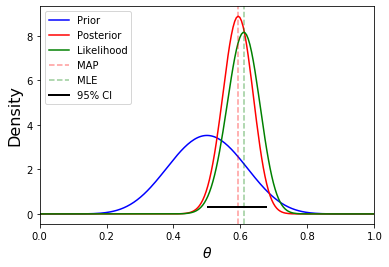

In [12]:
n = 100  # number of flips
h = 61  # number of heads
p = h/n  # probability of getting a heads

rv = stats.binom(n, p)
mu = rv.mean()


# a, b = 1, 1  # flat prior
# a, b = 100, 100  # strong prior
a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(h+a, n-h+b)  # analytic solution (i guess?)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left');

## Numerical integration

One simple way of numerical integration is to estimate the values on a grid of values for $\theta$
. To calculate the posterior, we find the prior and the likelihood for each value of $\theta$
, and for the marginal likelihood, we replace the integral with the equivalent sum

$$
p(X) = \sum_{\theta^*} p(X | \theta^*) p(\theta^*)
$$

One advantage of this is that the prior does not have to be conjugate (although the example below uses the same beta prior for ease of comparison), and so we are not restricted in our choice of an appropriate prior distribution. For example, the prior can be a mixture distribution or estimated empirically from data. The disadvantage, of course, is that this is computationally very expensive when we need to estimate multiple parameters, since the number of grid points grows as $\mathcal{O}(n^d)$, where n defines the grid resolution and d is the size of $\theta$.



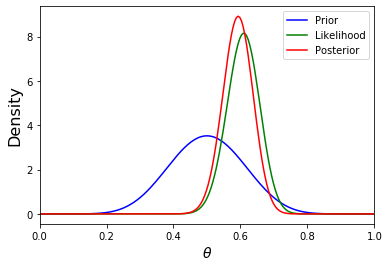

In [14]:
thetas = np.linspace(0, 1, 200)
prior = stats.beta(a, b)

_post = prior.pdf(thetas) * stats.binom(n, thetas).pmf(h)
# Normalzie so volume is 1
int_post = _post.sum() / len(thetas)
post = _post / int_post

plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend()
pass

## Markov Chain Monte Carlo (MCMC)

In Bayesian statistics, we want to estimate the posterior distribution, but this is often intractable due to the high-dimensional integral in the denominator (marginal likelihood). A few other ideas we have encountered that are also relevant here are Monte Carlo integration with independent samples and the use of proposal distributions (e.g. rejection and importance sampling). As we have seen from the Monte Carlo integration lectures, we can approximate the posterior $p(\theta |X)$
 if we can somehow draw many samples that come from the posterior distribution. With vanilla Monte Carlo integration, we need the samples to be independent draws from the posterior distribution, which is a problem if we do not actually know what the posterior distribution is (because we cannot integrate the marginal likelihood).
 
With MCMC, we draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain). Under certain conditions, the Markov chain will have a unique stationary distribution. In addition, not all samples are used - instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that ensure that the stationary distribution is the posterior distribution of interest. The nice thing is that this target distribution only needs to be proportional to the posterior distribution, which means we don’t need to evaluate the potentially intractable marginal likelihood, which is just a normalizing constant. We can find such a target distribution easily, since `posterior` ∝ `likelihood` × `prior`. After some time, the Markov chain of accepted draws will converge to the stationary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution in the same way as for vanilla Monte Carlo integration.

### Metropolis-Hastings random walk algorithm for estimating the bias of a coin

To carry out the Metropolis-Hastings algorithm, we need to draw random samples from the following distributions

 - the standard uniform distribution
 - a proposal distribution $p(x)$ that we choose to be $N(0,\sigma)$
 - the target distribution g(x)which is proportional to the posterior probability
 
Given an initial guess for $\theta$ with positive probability of being drawn, the Metropolis-Hastings algorithm proceeds as follows

 - Choose a new proposed value ($\theta_p$) such that $\theta_p=\theta+\Delta \theta$ where $\Delta \theta \sim N(0,\sigma)$ 
 - Caluculate the ratio
 
 $$
 \rho = \frac{g(\theta_p \ | \ X)}{g(\theta \ | \ X)}
 $$
 
 where $g$ is the posterior probability.
 
 Since we are taking ratios, the denominator cancels any distribution proportional to $g$ will also work - so we can use
 $$
 \rho = \frac{p(X | \theta_p ) p(\theta_p)}{p(X | \theta ) p(\theta)}
 $$
 
 - If $\rho \ge 1$, then set $\theta=\theta_p$
 - If $\rho<1$, then set $\theta=\theta_p$ with probability $ρ$, otherwise set $\theta=\theta$ (this is where we use the standard uniform distribution) 
 - Repeat the earlier steps
 
 
Note: If the proposal distribution is not symmetrical, we need to weight the acceptance probability to maintain detailed balance (reversibility) of the stationary distribution, and instead calculate

$$
\rho = \frac{g(\theta_p \ | \ X) p(\theta \ | \ \theta_p)}{g(\theta \ | \ X) p(\theta_p \ | \ \theta)}
$$

After some number of iterations k, the samples $\theta_{k+1} + \theta_{k+2} + \cdots$ will be samples from the posterior distributions. Here are initial concepts to help your intuition about why this is so:

 - We accept a proposed move to $\theta_{k+1}$ whenever the density of the (unnormalized) target distribution at $\theta_{k+1}$ is larger than the value of $\theta_{k}$
 - so $\theta$ will more often be found in places where the target distribution is denser
 - If this was all we accepted, $\theta$ would get stuck at a local mode of the target distribution, so we also accept occasional moves to lower density regions - it turns out that the correct probability of doing so is given by the ratio $\rho$
 - The acceptance criteria only looks at ratios of the target distribution, so the denominator cancels out and does not matter - that is why we only need samples from a distribution proportional to the posterior distribution
 - So, $\theta$ will be expected to bounce around in such a way that its spends its time in places proportional to the density of the posterior distribution - that is, $\theta$ is a draw from the posterior distribution.
 
Additional notes:

Different proposal distributions can be used for Metropolis-Hastings:

 - The independence sampler uses a proposal distribution that is independent of the current value of $\theta$. In this case the proposal distribution needs to be similar to the posterior distribution for efficiency, while ensuring that the acceptance ratio is bounded in the tail region of the posterior.
 - The random walk sampler (used in this example) takes a random step centered at the current value of $\theta$ - efficiency is a trade-off between small step size with high probability of acceptance and large step sizes with low probability of acceptance. Note (picture will be sketched in class) that the random walk may take a long time to traverse narrow regions of the probability distribution. Changing the step size (e.g. scaling $\Sigma$ for a multivariate normal proposal distribution) so that a target proportion of proposals are accepted is known as tuning.
 - Much research is being conducted on different proposal distributions for efficient sampling of the posterior distribution.
 
We will first see a numerical example and then try to understand why it works.

In [21]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print("Efficiency = ", naccept/niters)

Efficiency =  0.1892


/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


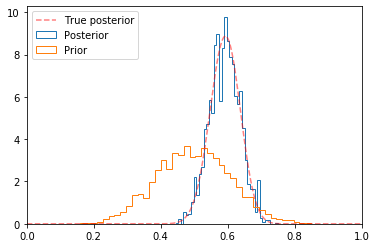

In [22]:
post = stats.beta(h+a, n-h+b)

plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Posterior');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Prior');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='upper left')
pass

In [23]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [24]:
n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100

sampless = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]
# Convergence of multiple chains

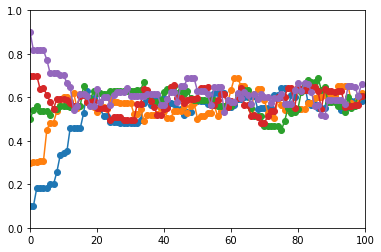

In [25]:
# Convergence of multiple chains

for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

#### Why does Metropolis-Hastings work?

There are two main ideas - first that the samples generated by MCMC constitute a Markov chain, and that this Markov chain has a unique stationary distribution that is always reached if we generate a very large number of samples. The second idea is to show that this stationary distribution is exactly the posterior distribution that we are looking for. We will only give the intuition here as a refresher.